# Chapter 6. 학습 관련 기술들

In [1]:
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

## 6.1 매개변수 갱신

### 6.1.1 모험가 이야기

### 6.1.2 확률적 경사 하강법(SGD)

In [2]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

<br>

### 6.1.3 SGD의 단점

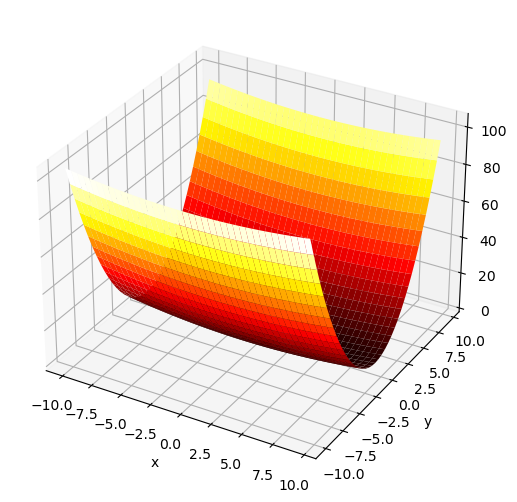

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
XX, YY = np.meshgrid(X, Y)
ZZ = (1 / 20) * XX**2 + YY**2

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, cmap='hot');

Text(0, 0.5, 'Y')

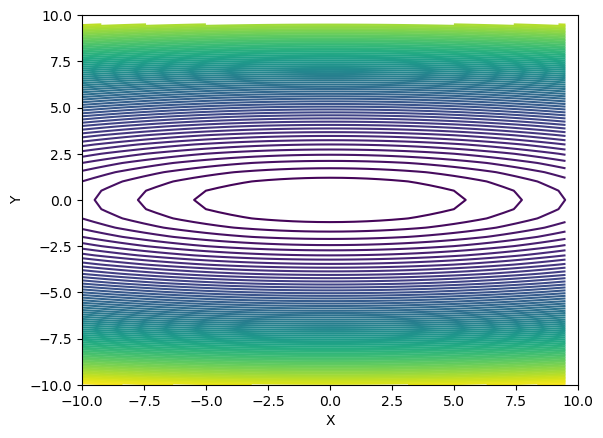

In [4]:
plt.contour(XX, YY, ZZ, 100)
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.xlabel('X')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


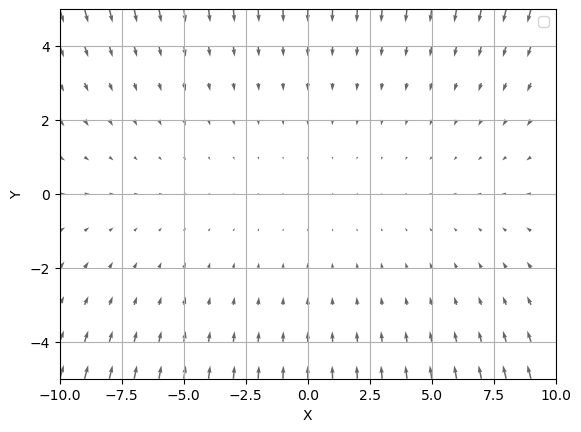

In [5]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

from mpl_toolkits.mplot3d import Axes3D

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)
     
x0 = np.arange(-10, 10, 1)
x1 = np.arange(-10, 10, 1)
X, Y = np.meshgrid(x0, x1)
    
X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([(1/(20**0.5))*X, Y]) )
    
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.draw()
plt.show()

<br>

### 6.1.4 모멘텀

In [6]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

<br>

### 이외의 기법: Nesterov

In [7]:
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

<br>

### 6.1.5 AdaGrad

In [8]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

<br>

In [9]:
### 이외의 기법: RMSprop

In [10]:
class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

<br>

### 6.1.6 Adam

In [11]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

<br>

### 6.1.7 어느 갱신 방법을 이용할 것인가?

In [12]:
# coding: utf-8
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


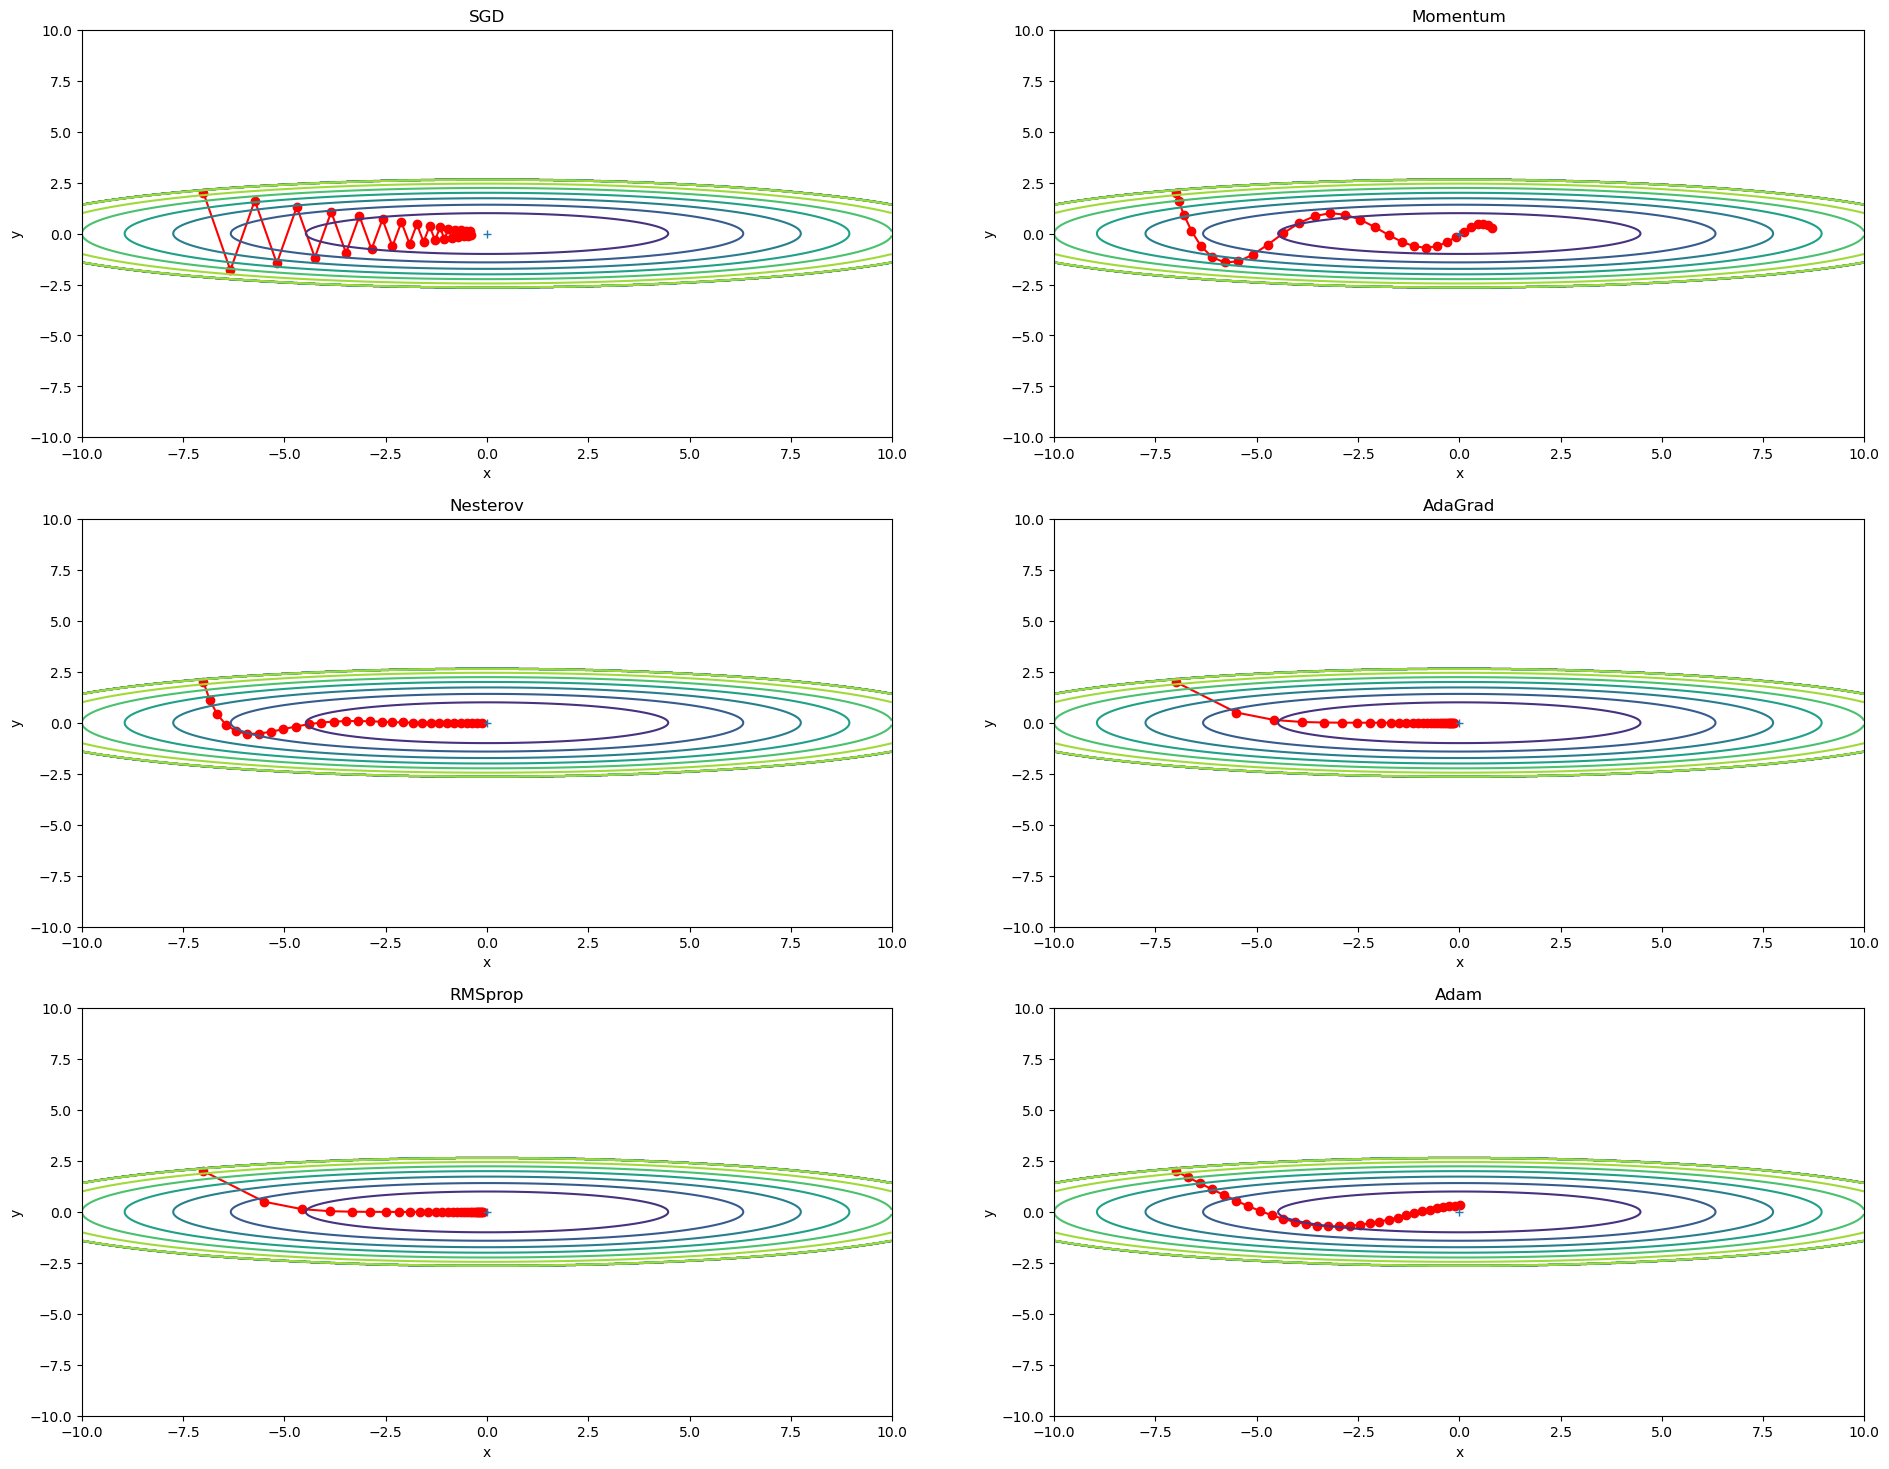

In [13]:
# coding: utf-8
# import sys, os
# sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
# from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["Nesterov"] = Nesterov(lr=0.08)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["RMSprop"] = RMSprop(lr=0.15)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
plt.figure(figsize=(23, 18))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(3, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()


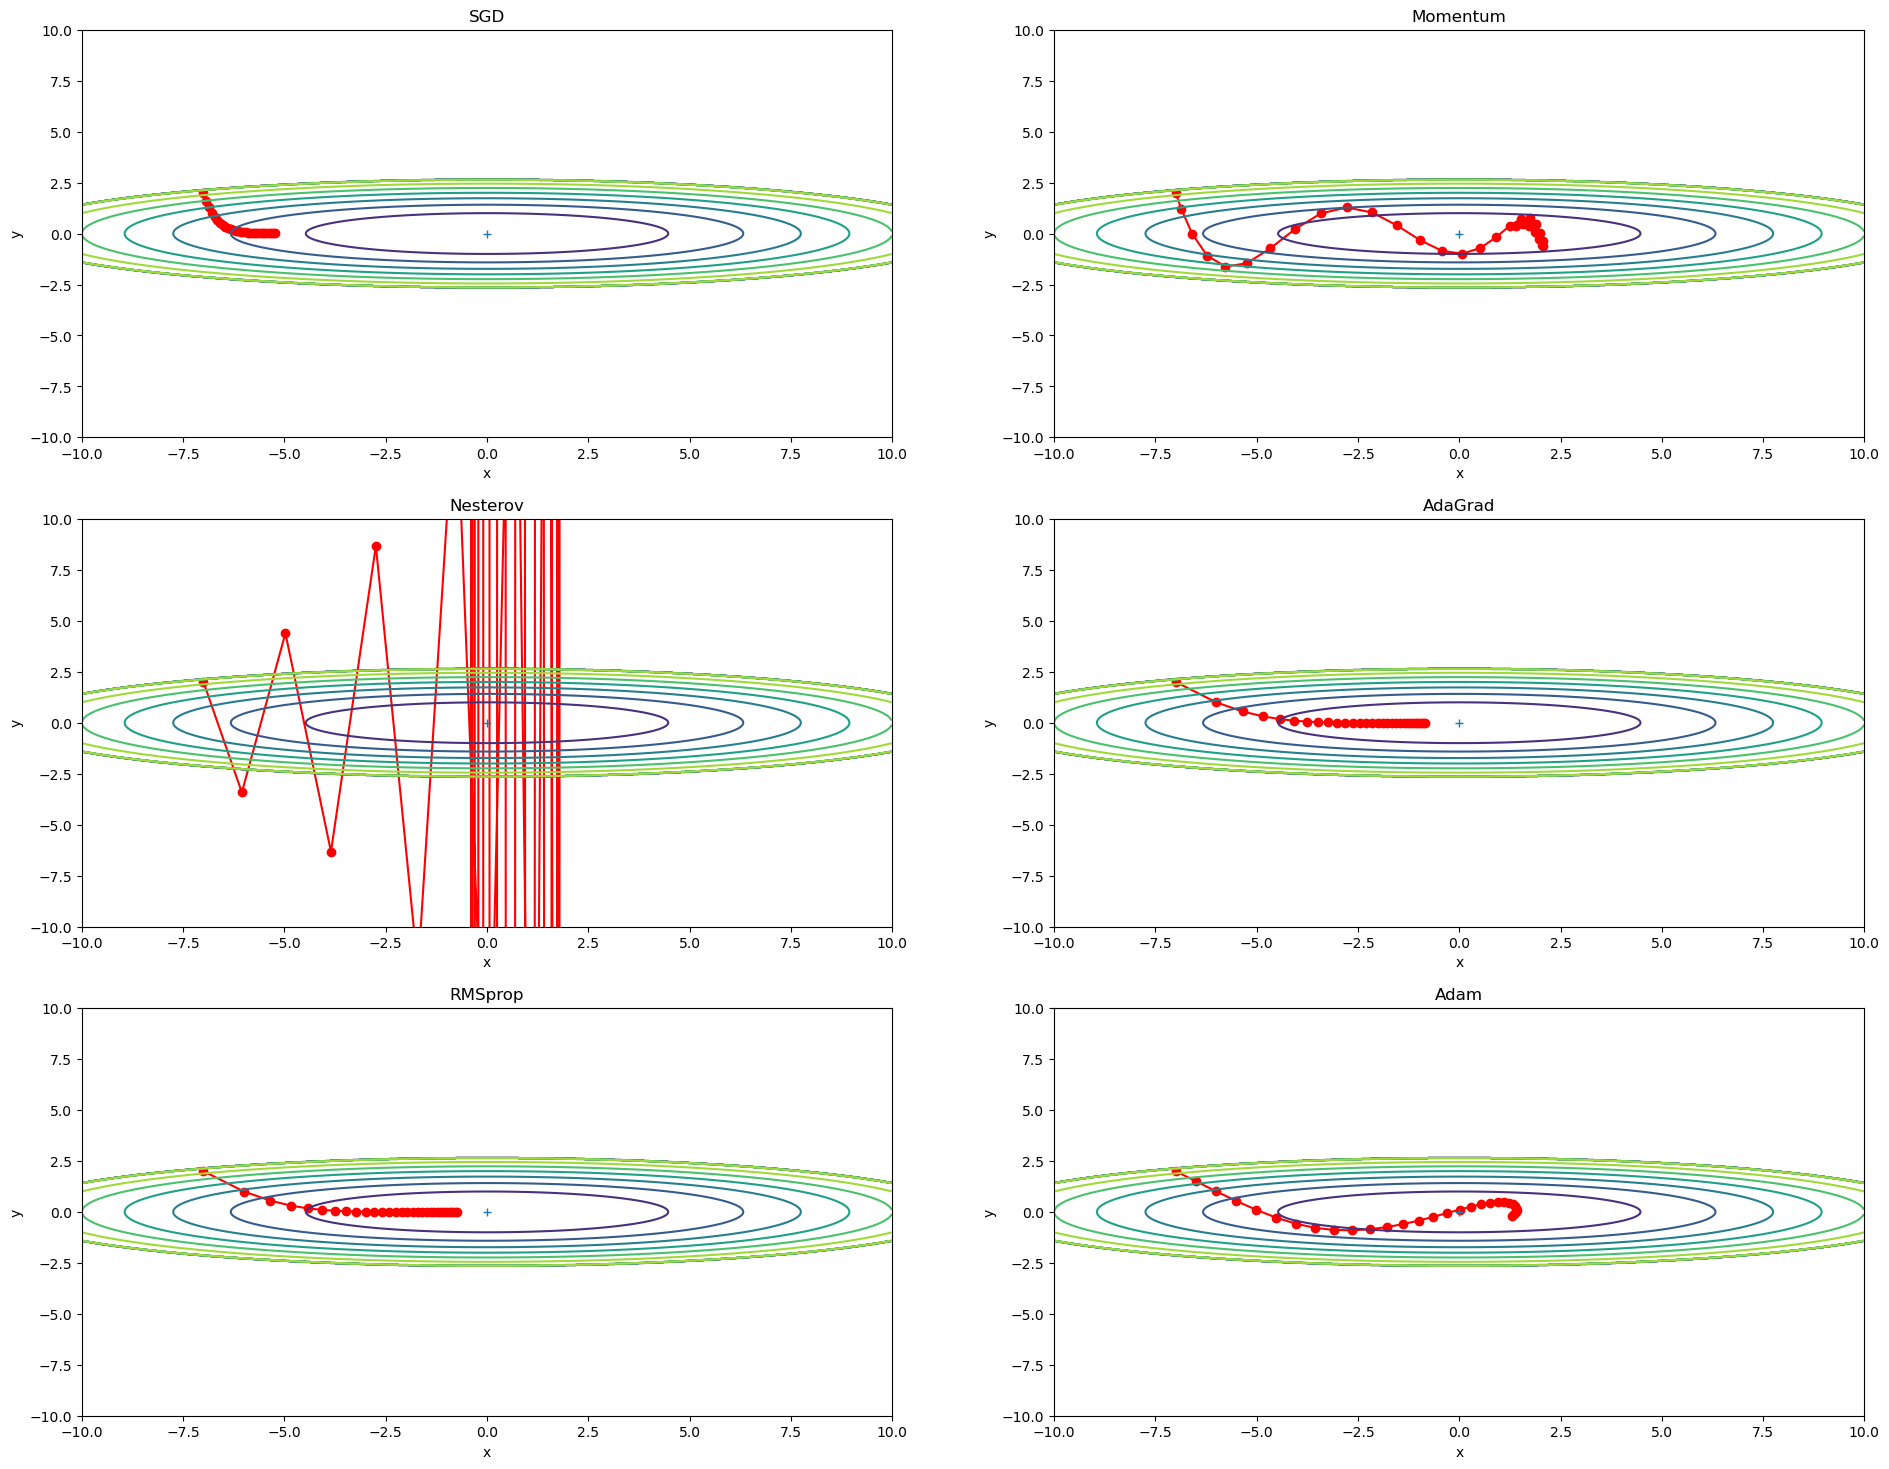

In [14]:
# coding: utf-8
# import sys, os
# sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
# from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.1)
optimizers["Momentum"] = Momentum(lr=0.2)
optimizers["Nesterov"] = Nesterov(lr=0.5)
optimizers["AdaGrad"] = AdaGrad(lr=1.0)
optimizers["RMSprop"] = RMSprop(lr=0.1)
optimizers["Adam"] = Adam(lr=0.5)

idx = 1
plt.figure(figsize=(23, 18))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(3, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()


<br>

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

===========iteration:0===========
SGD:2.3337360175179556
Momentum:2.313339843160491
Nesterov:2.306003841961706
AdaGrad:2.115681265493535
RMSprop:14.217545861405078
Adam:2.20931082405143
===========iteration:100===========
SGD:1.585391534842315
Momentum:0.3962444371593643
Nesterov:0.2937070028368133
AdaGrad:0.19649671969626148
RMSprop:0.43637481420248764
Adam:0.2911378531099449
===========iteration:200===========
SGD:0.831005599959888
Momentum:0.26461272919845646
Nesterov:0.20356571637947884
AdaGrad:0.09427737464220534
RMSprop:0.2165587563240987
Adam:0.15827026632878824
===========iteration:300===========
SGD:0.6180204774634408
Momentum:0.17251913122517495
Nesterov:0.11512842660003095
AdaGrad:0.07625228635864292
RMSprop:0.12754374011108519
Adam:0.10812965872482484
===========iteration:400===========
SGD:0.6000894525109222
Momentum:0.2792339201406983
Nesterov:0.22254516722555673
AdaGrad:0.179112010053886
RMSprop:0.29938289145631936
Adam:0.2387579414858773
===========iteration:500========

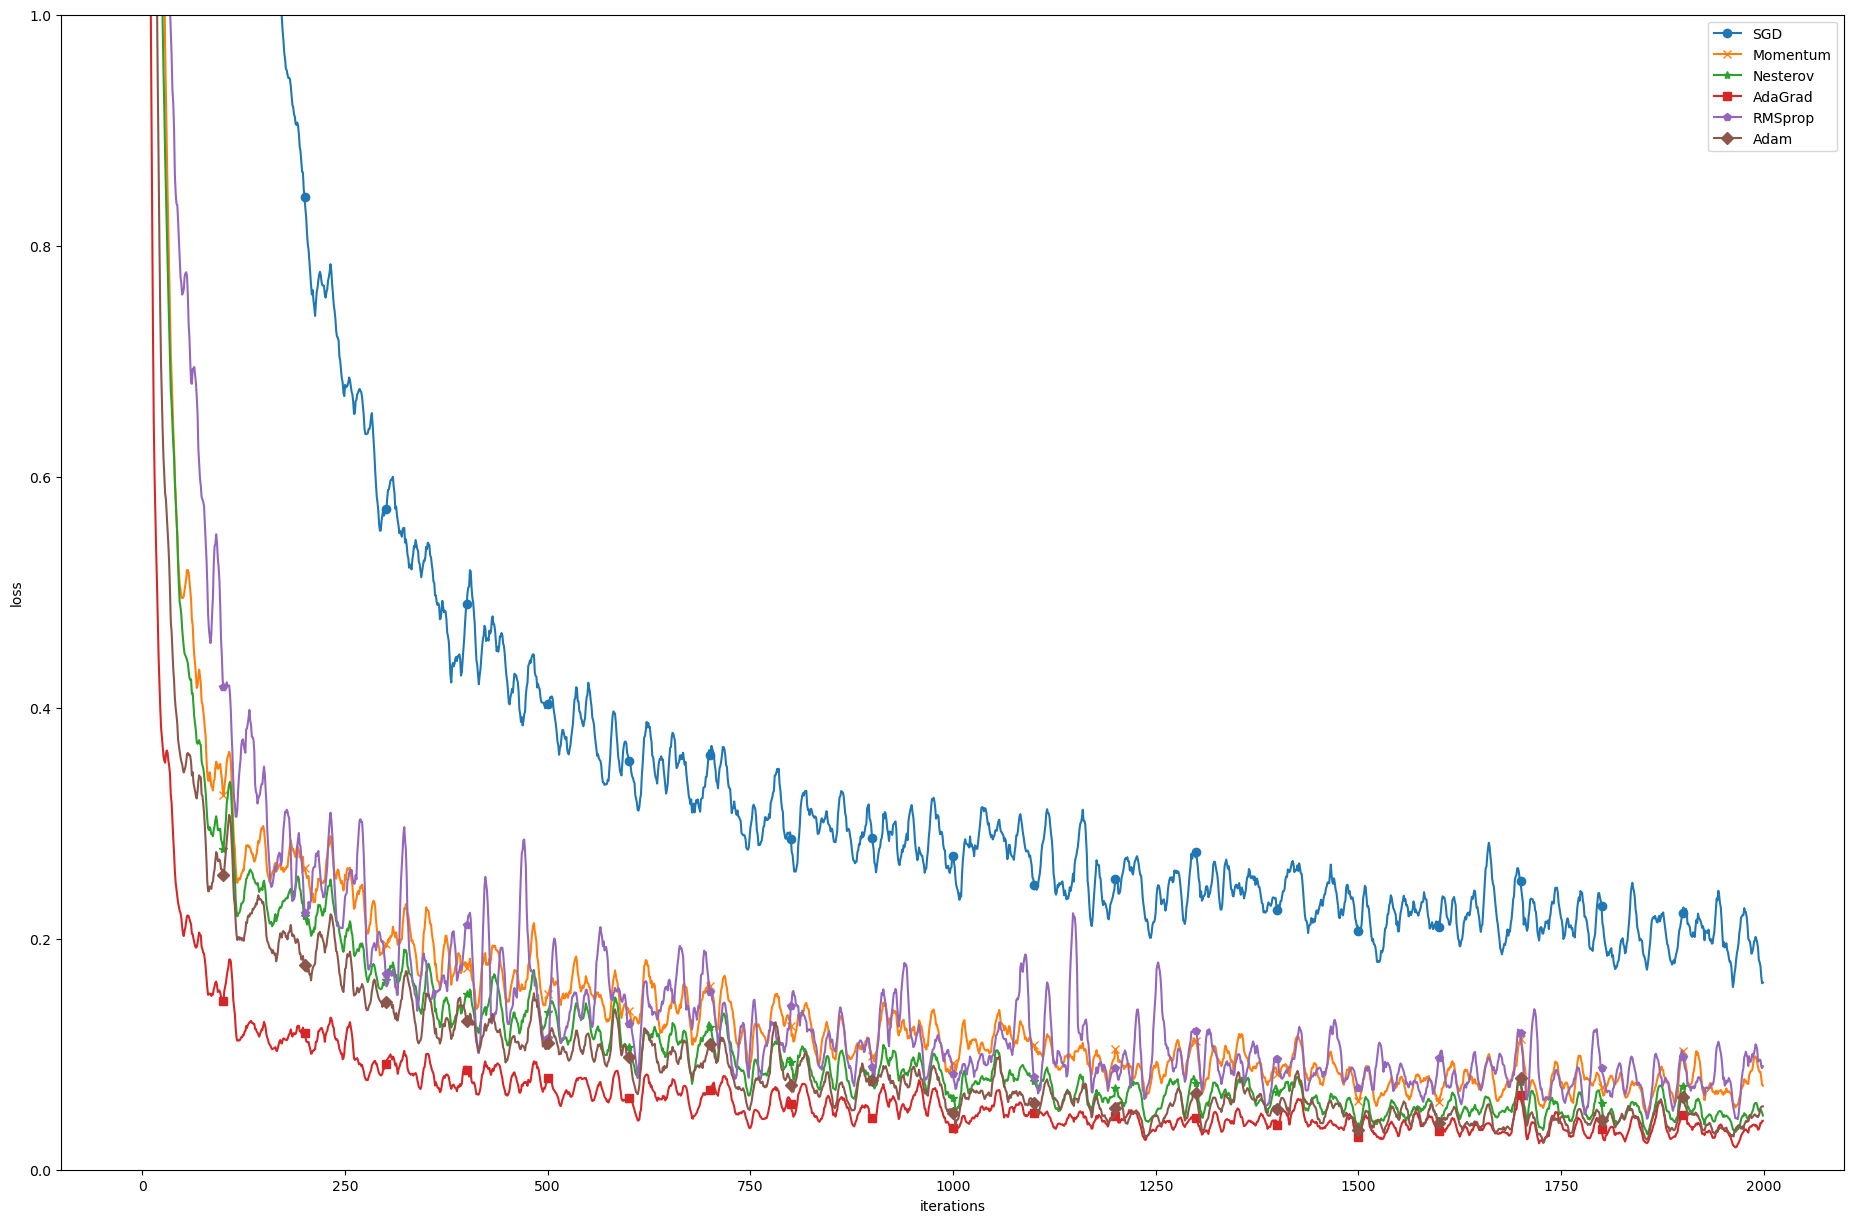

In [15]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['Nesterov'] = Nesterov()
optimizers['AdaGrad'] = AdaGrad()
optimizers['RMSprop'] = RMSprop()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
plt.figure(figsize=(23, 15))
markers = {"SGD": "o", "Momentum": "x", "Nesterov": "*", "AdaGrad": "s", "RMSprop": "p", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


<br>

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면?

### 6.2.2 은닉층의 활성화값 분포

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [17]:
activations = {}  # 이곳에 활성화 결과를 저장

def get_activation(hidden_layer_size, x, w, sigmoid):
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        # 활성화 함수도 바꿔가며 실험해보자！
        z = sigmoid(a)
        # z = ReLU(a)
        # z = tanh(a)

        activations[i] = z
    return activations


# 히스토그램 그리기
def get_histogram(activations):
    plt.figure(figsize=(15, 5))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

In [18]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개

x = input_data

# 초깃값을 다양하게 바꿔가며 실험해보자！
w = np.random.randn(node_num, node_num) * 1
# w = np.random.randn(node_num, node_num) * 0.01
# w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
# w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

z = sigmoid
# z = ReLU
# z = tanh

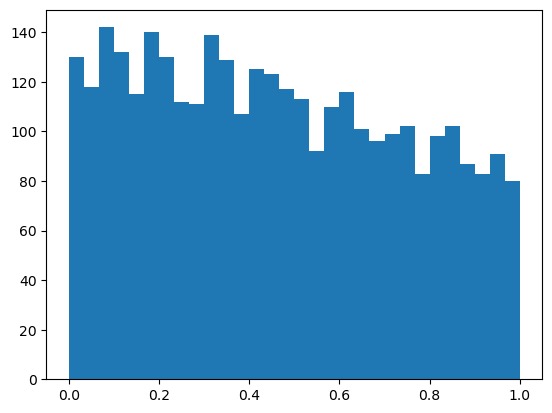

In [19]:
plt.hist(w.flatten(), 30, range=(0,1))
plt.show()

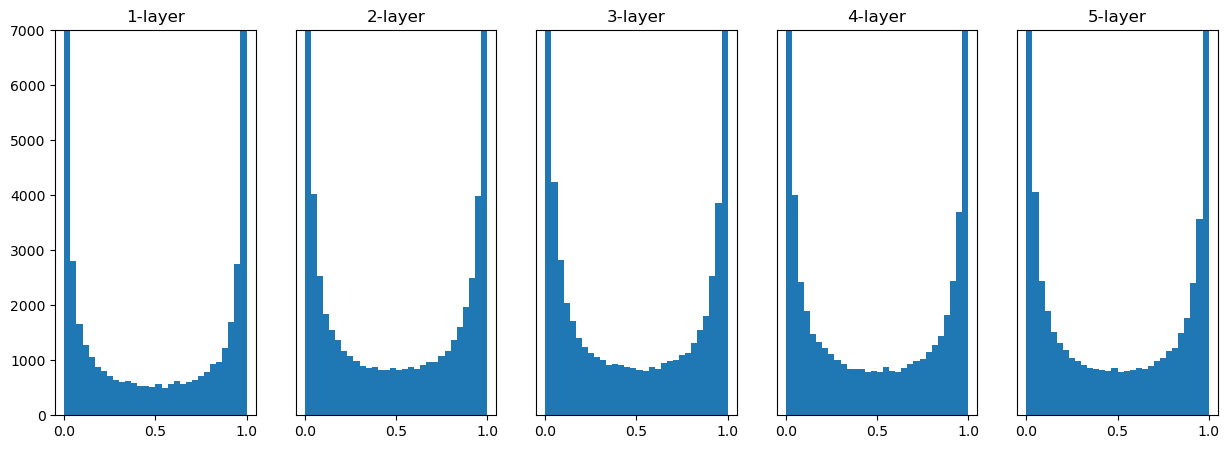

In [20]:
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

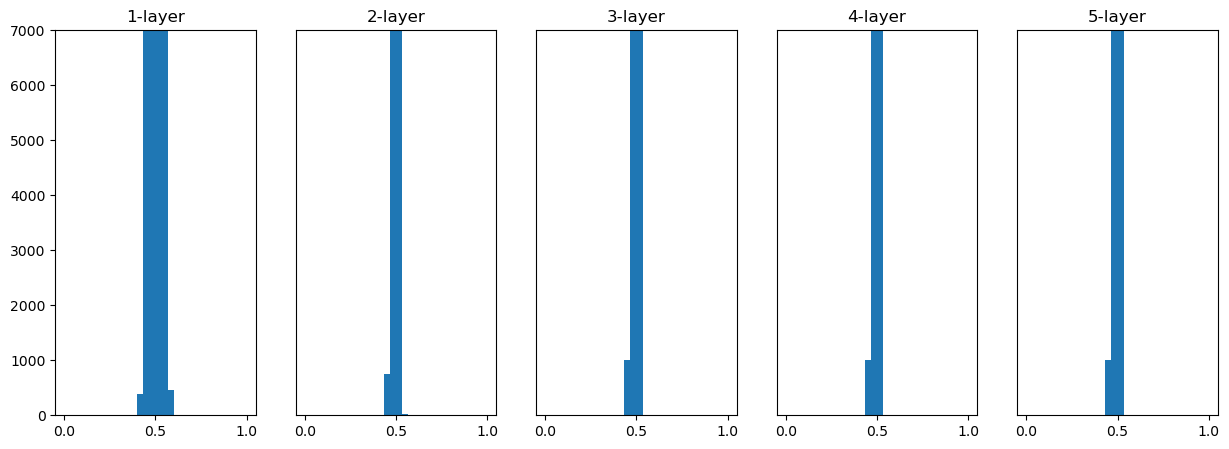

In [21]:
x = input_data
w = np.random.randn(node_num, node_num) * 0.01
z = sigmoid

activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

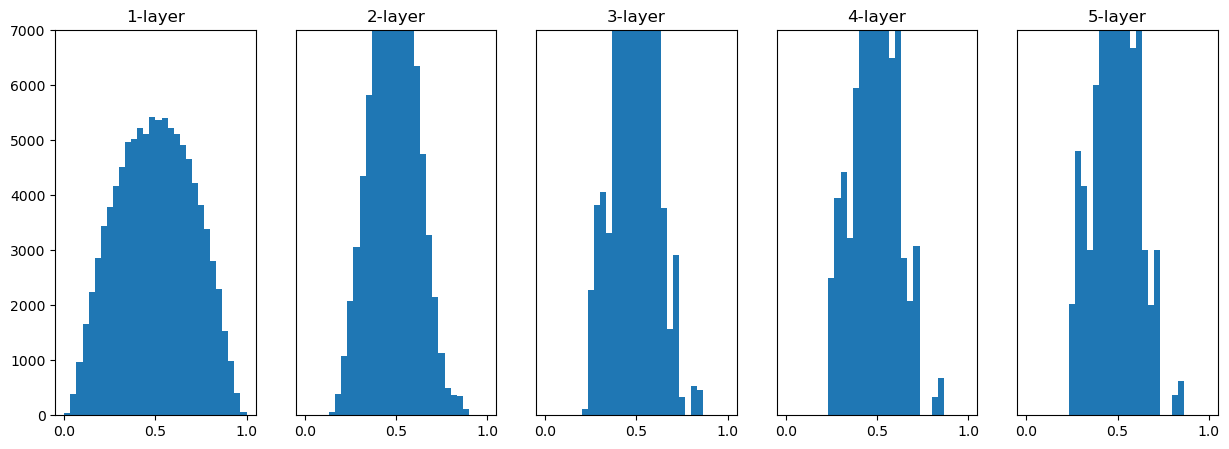

In [22]:
x = input_data
# Xavier 초기값
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
z = sigmoid

activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

<br>

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값

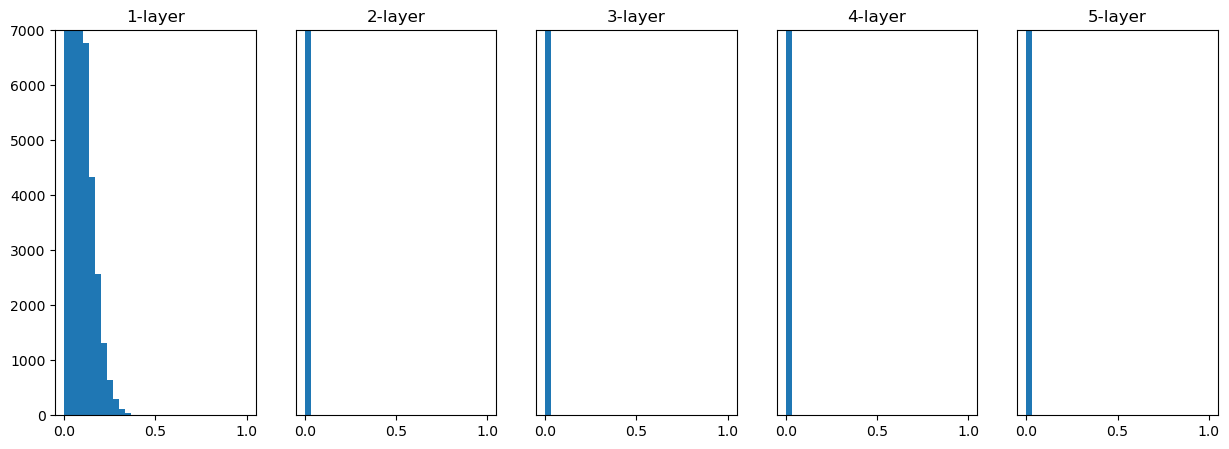

In [23]:
# 표준편차가 0.01인 정규분포를 가중치 초기값으로 사용한 경우
x = input_data
w = np.random.randn(node_num, node_num) * 0.01
z = ReLU

activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

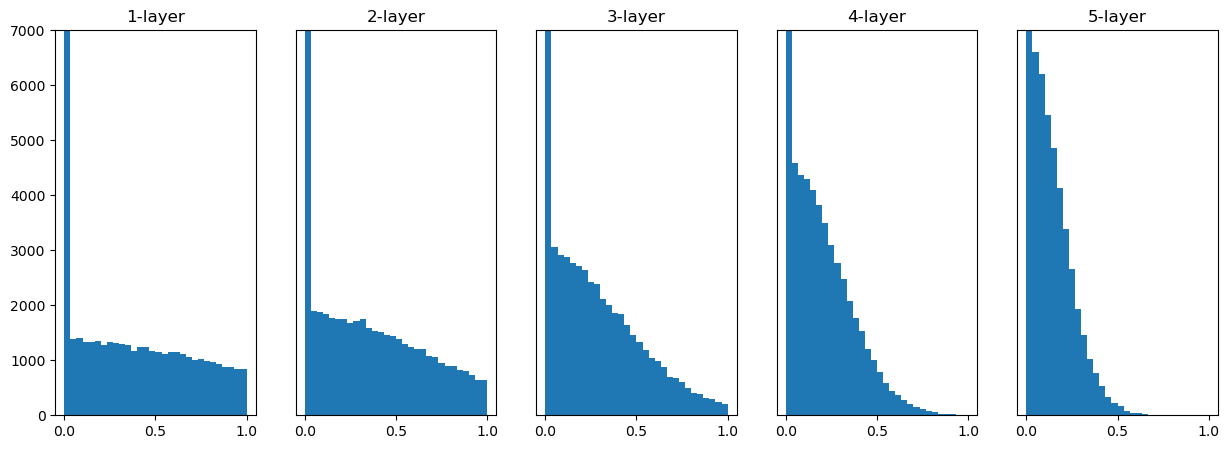

In [24]:
# Xavier 초기값을 사용한 경우
x = input_data
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
z = ReLU

activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

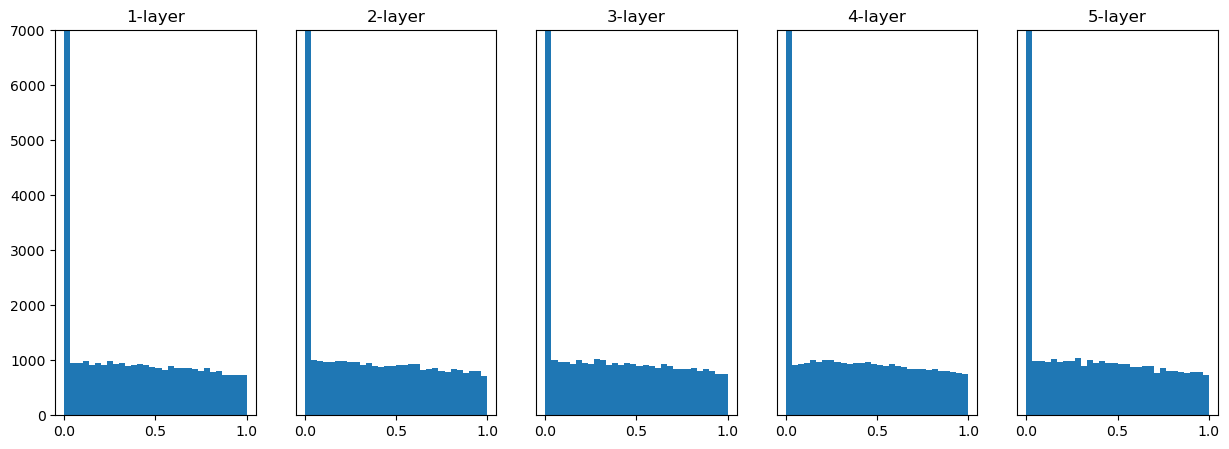

In [25]:
# He 초기값을 사용한 경우
x = input_data
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
z = ReLU

activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

<br>

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.3025303309297325
Xavier:2.3109546558621763
He:2.334592151677196
===========iteration:100===========
std=0.01:2.301787305831861
Xavier:2.236842574821087
He:1.7046262959120402
===========iteration:200===========
std=0.01:2.299926250676078
Xavier:2.0969056035681204
He:0.7825383880339528
===========iteration:300===========
std=0.01:2.3017443763716416
Xavier:1.7780111118692954
He:0.6162767776892936
===========iteration:400===========
std=0.01:2.301903361074275
Xavier:1.1529385422711256
He:0.4417767460669366
===========iteration:500===========
std=0.01:2.3005662392113733
Xavier:0.7332497995569123
He:0.35904357684436206
===========iteration:600===========
std=0.01:2.303372696651447
Xavier:0.6217412750440254
He:0.384619603754923
===========iteration:700===========
std=0.01:2.3055791537111645
Xavier:0.49760900734248215
He:0.32248403578071483
===========iteration:800===========
std=0.01:2.3032606346999254
Xavier:0.29449396986838433
He:0.22886990297743

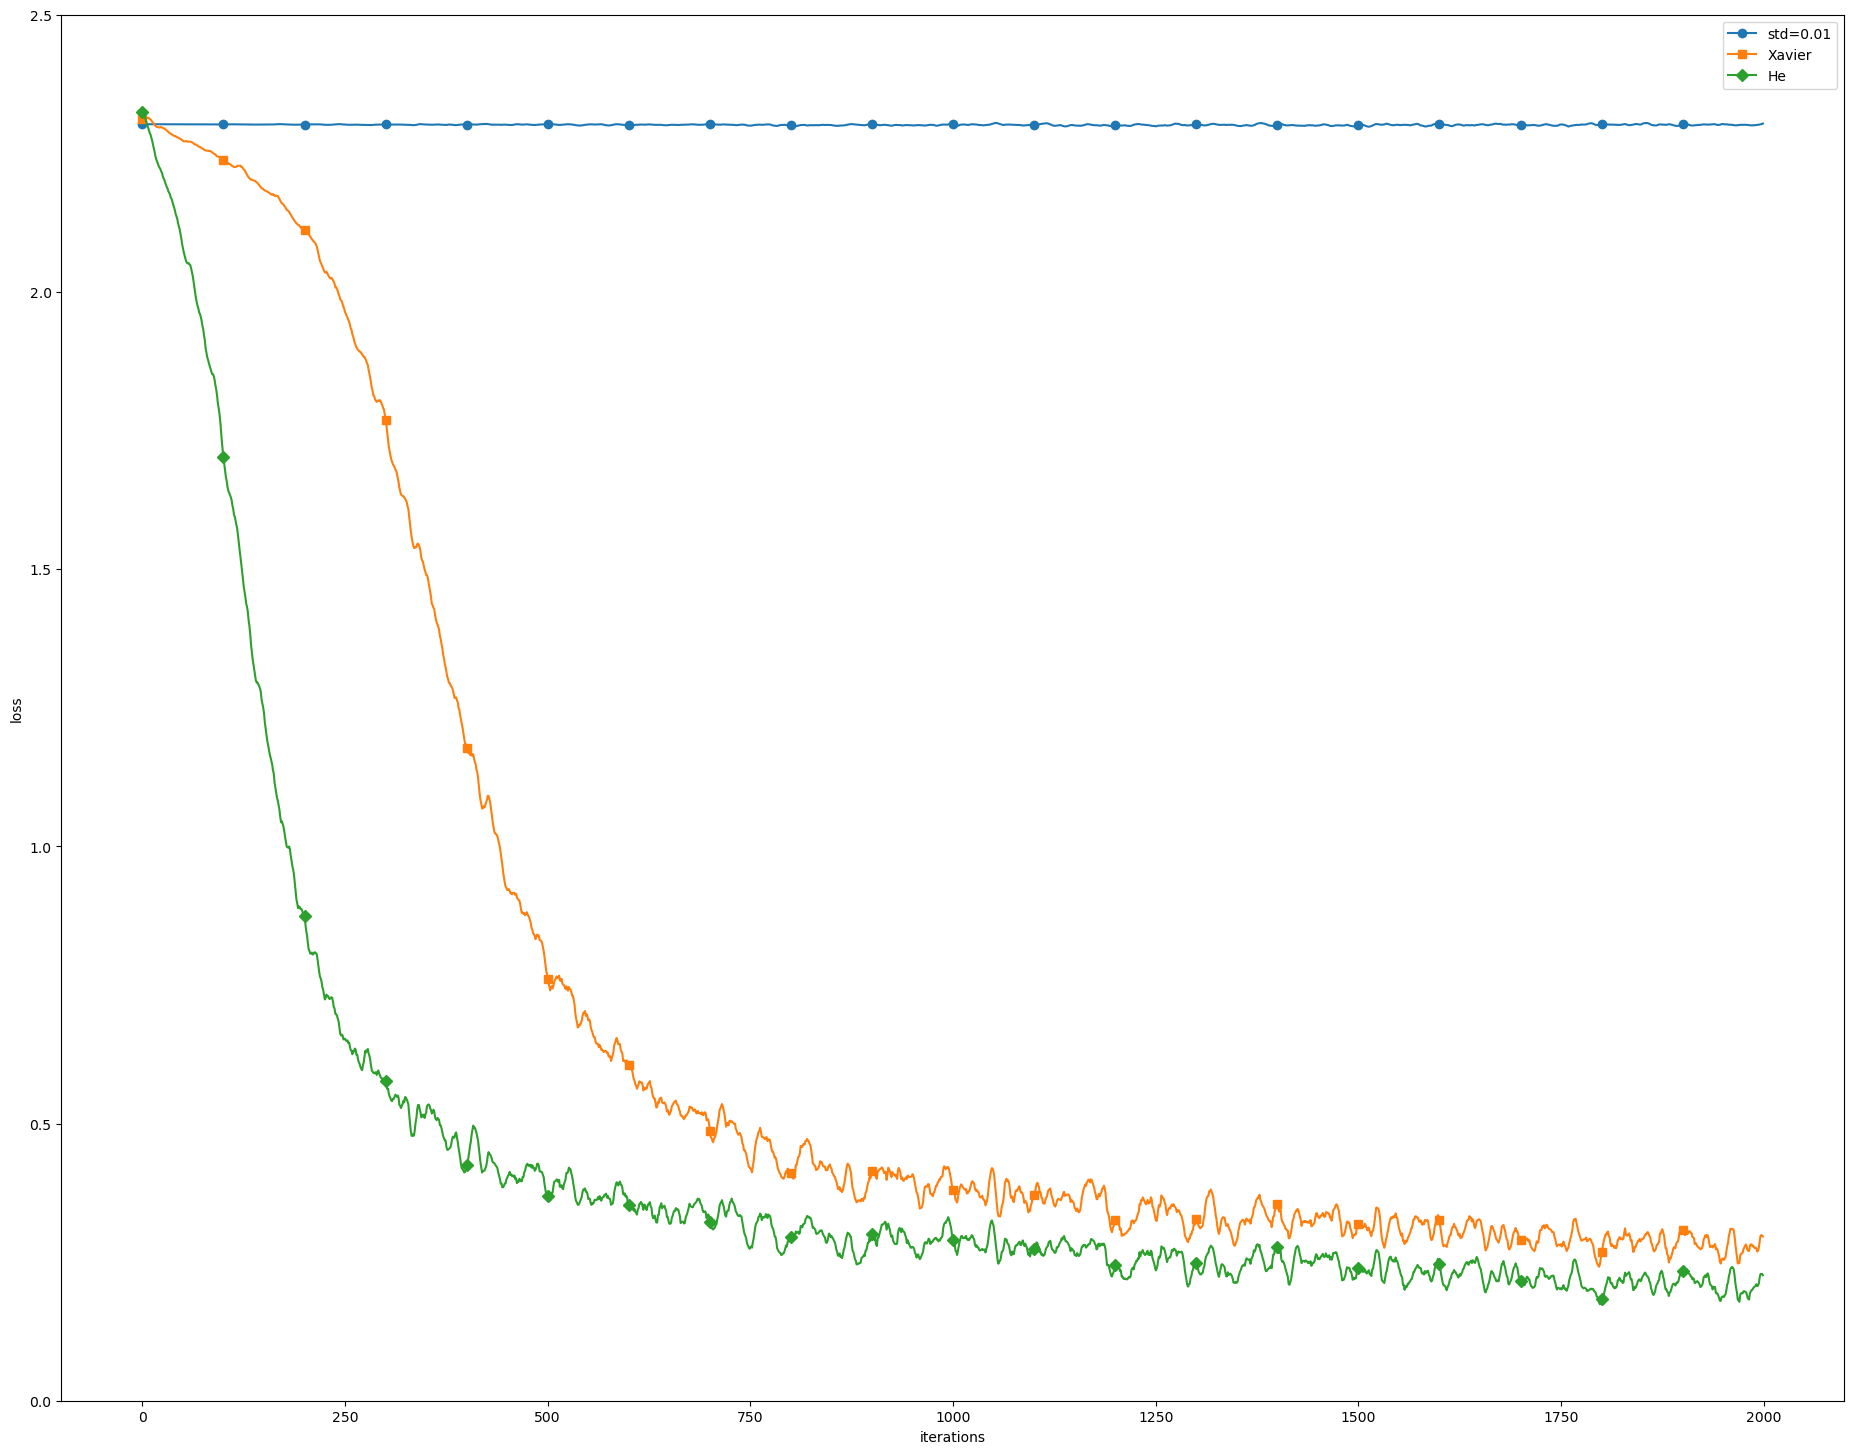

In [26]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
plt.figure(figsize=(23, 18))
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

<br>

## 6.3 배치 정규화

### 6.3.1 배치 정규화 알고리즘

### 6.3.2 배치 정규화의 효과

============== 1/16 ==============
epoch:0 | 0.093 - 0.101
epoch:1 | 0.097 - 0.086
epoch:2 | 0.097 - 0.094
epoch:3 | 0.097 - 0.101
epoch:4 | 0.097 - 0.133
epoch:5 | 0.097 - 0.143
epoch:6 | 0.097 - 0.164
epoch:7 | 0.097 - 0.173
epoch:8 | 0.097 - 0.196
epoch:9 | 0.097 - 0.225
epoch:10 | 0.097 - 0.237
epoch:11 | 0.097 - 0.253
epoch:12 | 0.097 - 0.284
epoch:13 | 0.097 - 0.302
epoch:14 | 0.097 - 0.318
epoch:15 | 0.097 - 0.334
epoch:16 | 0.097 - 0.352
epoch:17 | 0.097 - 0.353
epoch:18 | 0.097 - 0.378
epoch:19 | 0.097 - 0.392
============== 2/16 ==============
epoch:0 | 0.093 - 0.13
epoch:1 | 0.097 - 0.117
epoch:2 | 0.097 - 0.132
epoch:3 | 0.097 - 0.177
epoch:4 | 0.097 - 0.2
epoch:5 | 0.097 - 0.221
epoch:6 | 0.097 - 0.249
epoch:7 | 0.097 - 0.263
epoch:8 | 0.097 - 0.274
epoch:9 | 0.097 - 0.305
epoch:10 | 0.097 - 0.321
epoch:11 | 0.097 - 0.345
epoch:12 | 0.097 - 0.375
epoch:13 | 0.097 - 0.393
epoch:14 | 0.097 - 0.412
epoch:15 | 0.097 - 0.437
epoch:16 | 0.097 - 0.448
epoch:17 | 0.097 - 0.467
epo

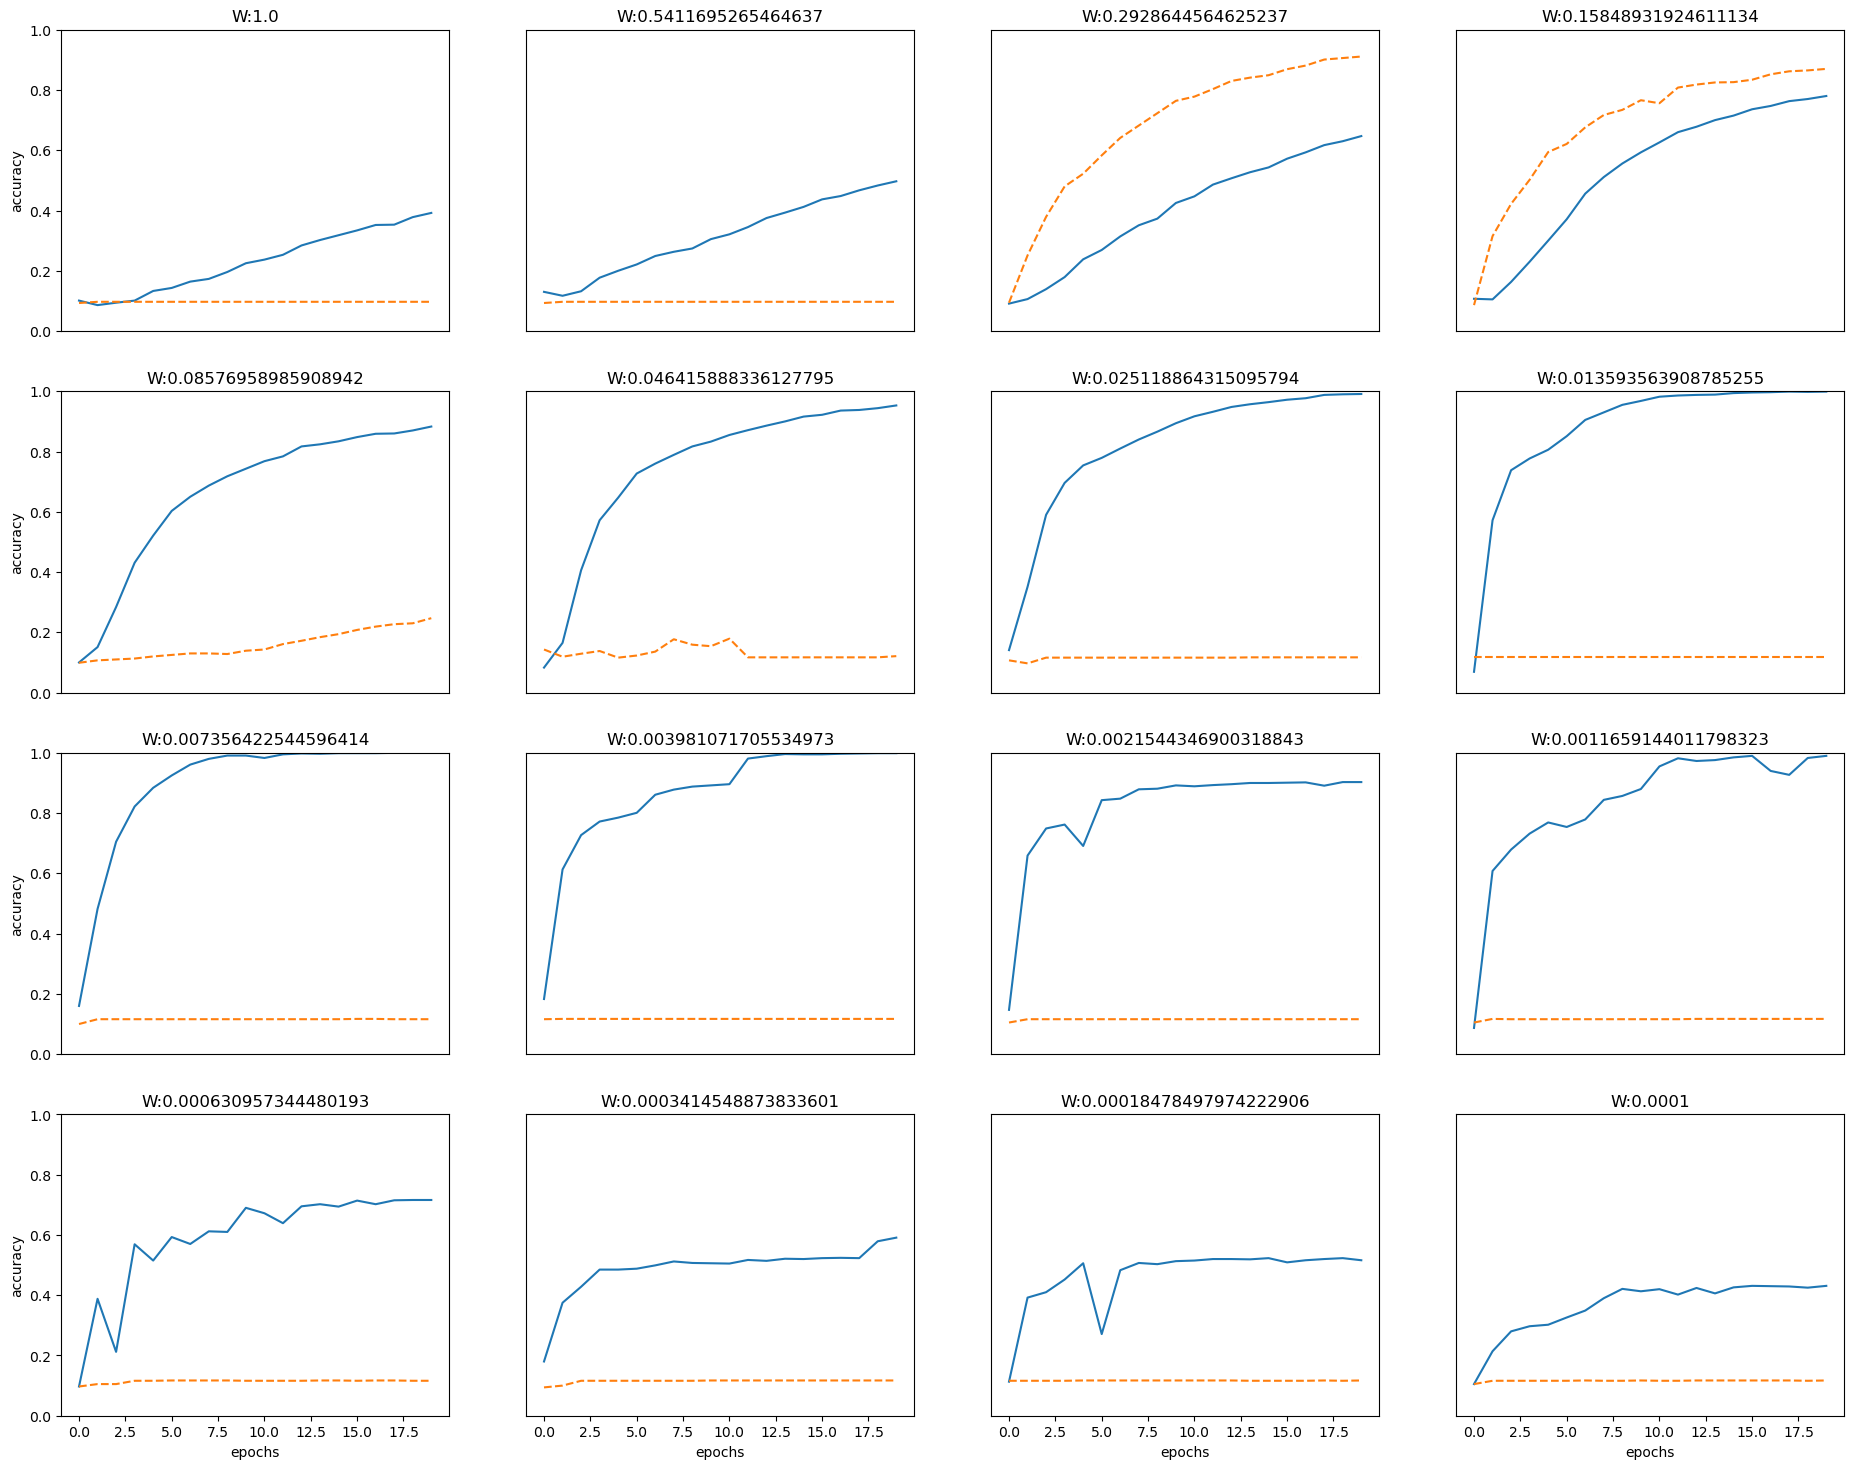

In [27]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
plt.figure(figsize=(23, 18))
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    #plt.legend(loc='lower right')
    
plt.show()


<br>

## 6.4 바른 학습을 위해

### 6.4.1 오버피팅

epoch:0, train acc:0.1, test acc:0.0991
epoch:1, train acc:0.1, test acc:0.0975
epoch:2, train acc:0.1, test acc:0.0975
epoch:3, train acc:0.1, test acc:0.0975
epoch:4, train acc:0.10333333333333333, test acc:0.1015
epoch:5, train acc:0.12333333333333334, test acc:0.1051
epoch:6, train acc:0.13, test acc:0.1105
epoch:7, train acc:0.14, test acc:0.1143
epoch:8, train acc:0.15, test acc:0.1191
epoch:9, train acc:0.17, test acc:0.1268
epoch:10, train acc:0.18, test acc:0.1329
epoch:11, train acc:0.21, test acc:0.1452
epoch:12, train acc:0.23, test acc:0.1598
epoch:13, train acc:0.24666666666666667, test acc:0.1747
epoch:14, train acc:0.26, test acc:0.1891
epoch:15, train acc:0.27, test acc:0.1989
epoch:16, train acc:0.31, test acc:0.2096
epoch:17, train acc:0.3433333333333333, test acc:0.2224
epoch:18, train acc:0.35333333333333333, test acc:0.2305
epoch:19, train acc:0.36666666666666664, test acc:0.2398
epoch:20, train acc:0.4, test acc:0.2511
epoch:21, train acc:0.39666666666666667, tes

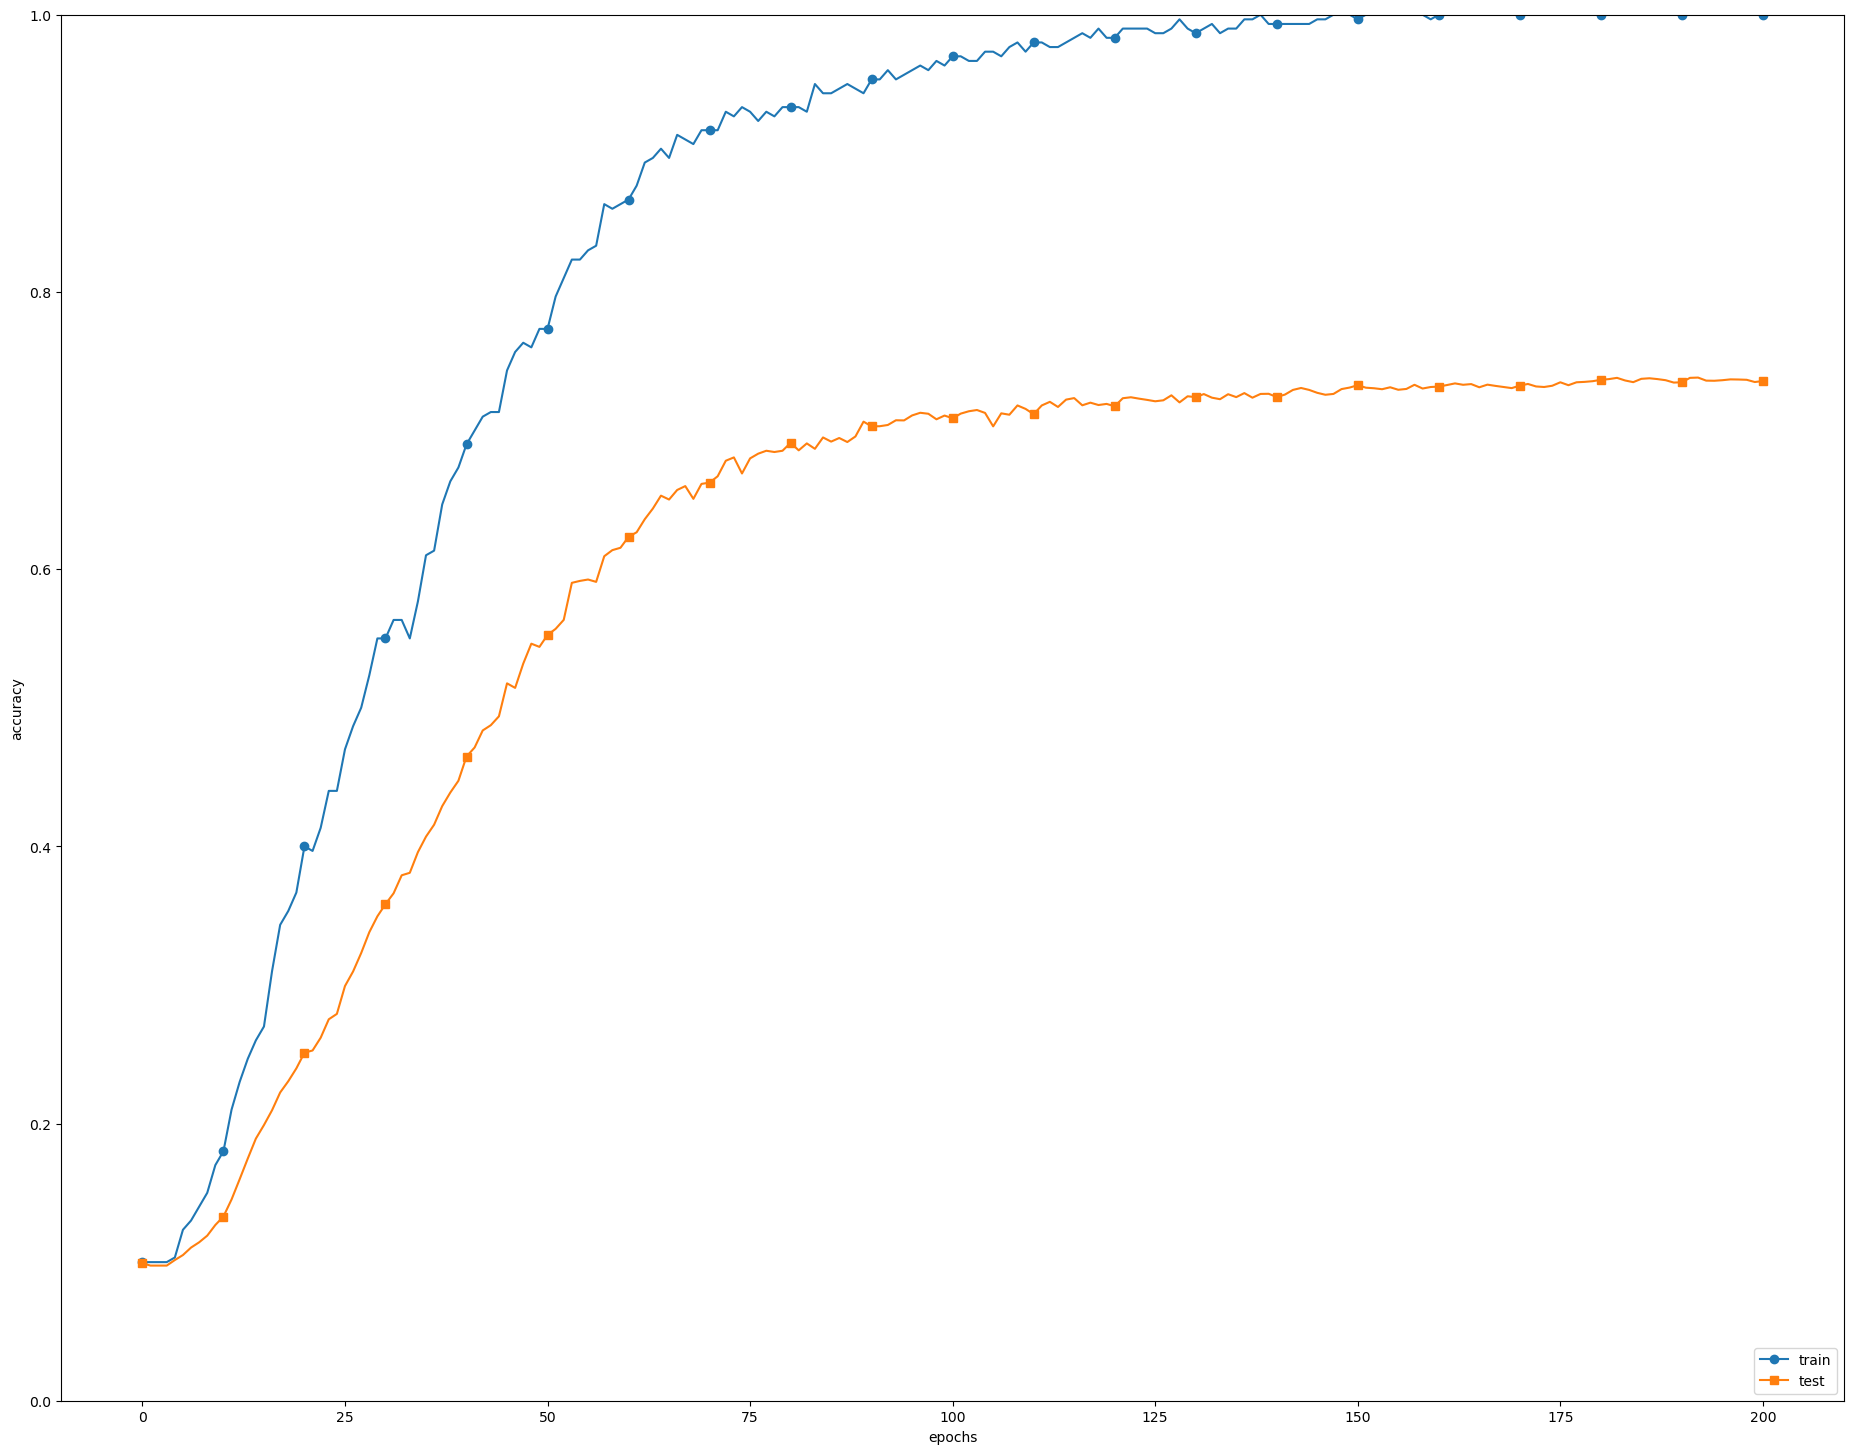

In [28]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
plt.figure(figsize=(23, 18))
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


<br>

### 6.4.2 가중치 감소

epoch:0, train acc:0.1, test acc:0.102
epoch:1, train acc:0.11333333333333333, test acc:0.1124
epoch:2, train acc:0.12, test acc:0.1184
epoch:3, train acc:0.14666666666666667, test acc:0.1261
epoch:4, train acc:0.16, test acc:0.133
epoch:5, train acc:0.19333333333333333, test acc:0.1541
epoch:6, train acc:0.2, test acc:0.1591
epoch:7, train acc:0.26, test acc:0.2055
epoch:8, train acc:0.30333333333333334, test acc:0.2394
epoch:9, train acc:0.36666666666666664, test acc:0.277
epoch:10, train acc:0.38666666666666666, test acc:0.2836
epoch:11, train acc:0.4033333333333333, test acc:0.3097
epoch:12, train acc:0.43, test acc:0.3258
epoch:13, train acc:0.43666666666666665, test acc:0.3264
epoch:14, train acc:0.44333333333333336, test acc:0.3402
epoch:15, train acc:0.4866666666666667, test acc:0.373
epoch:16, train acc:0.4666666666666667, test acc:0.3682
epoch:17, train acc:0.4766666666666667, test acc:0.377
epoch:18, train acc:0.5133333333333333, test acc:0.4045
epoch:19, train acc:0.5333333

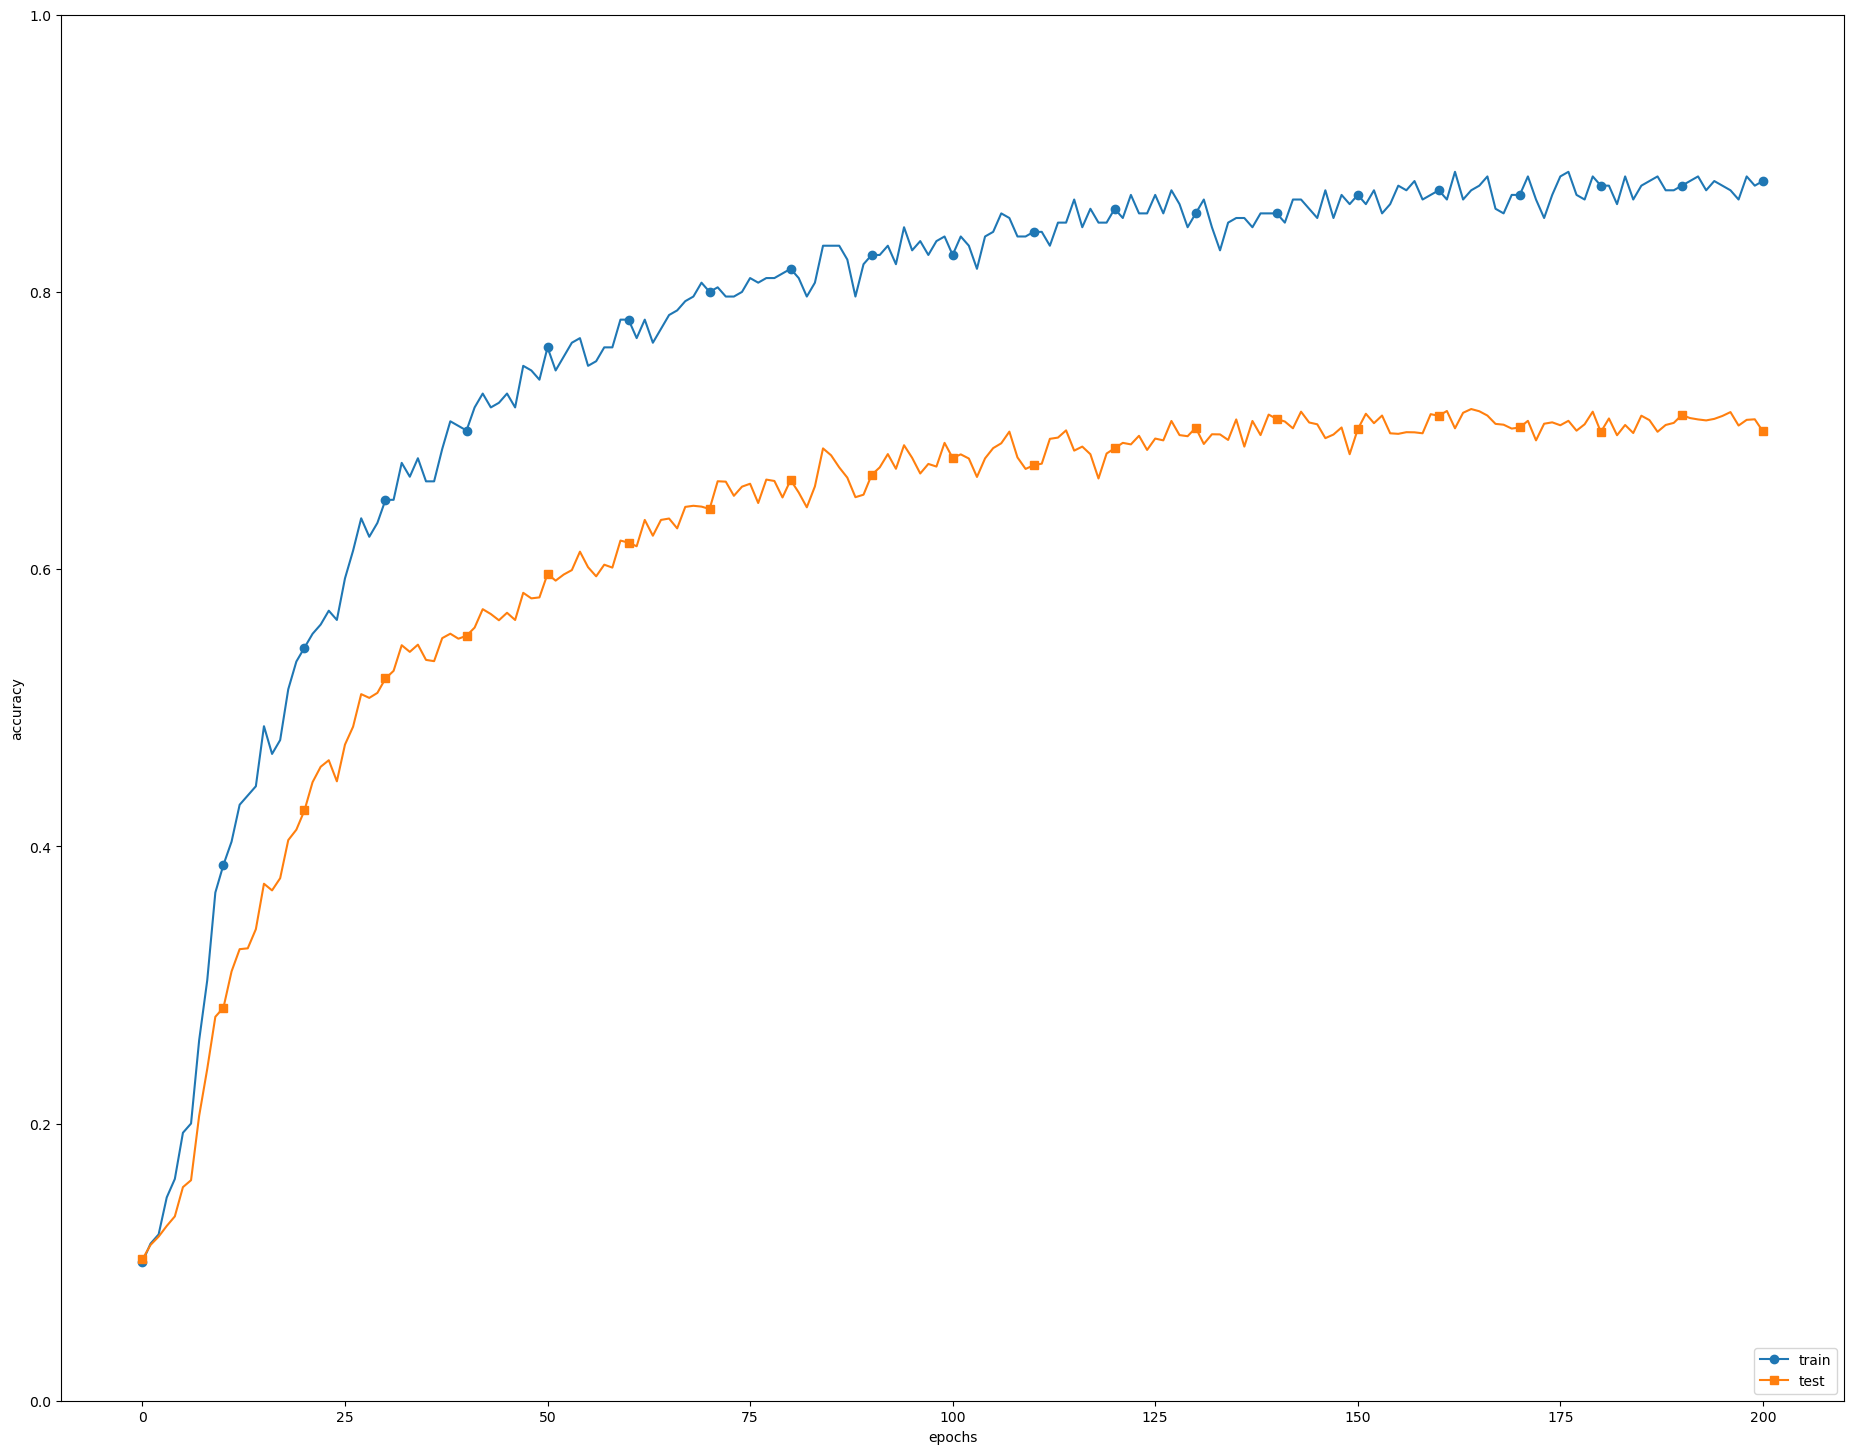

In [29]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
plt.figure(figsize=(23, 18))
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


<br>

### 6.4.3 드롭아웃

train loss:2.4612174362846115
=== epoch:1, train acc:0.09, test acc:0.0941 ===
train loss:2.372218077779715
train loss:2.3554517035696962
train loss:2.408444491767293
=== epoch:2, train acc:0.10333333333333333, test acc:0.0948 ===
train loss:2.3976422117173484
train loss:2.2031152512006926
train loss:2.2755361235890716
=== epoch:3, train acc:0.11333333333333333, test acc:0.1015 ===
train loss:2.285883080059755
train loss:2.259446019879428
train loss:2.23558353823249
=== epoch:4, train acc:0.14, test acc:0.1217 ===
train loss:2.2639981921335464
train loss:2.2888330020905765
train loss:2.2180931481833204
=== epoch:5, train acc:0.16666666666666666, test acc:0.1401 ===
train loss:2.239529431311159
train loss:2.1786703895990276
train loss:2.109316039545759
=== epoch:6, train acc:0.19, test acc:0.1553 ===
train loss:2.2035663725067884
train loss:2.163229407400001
train loss:2.1460595720346864
=== epoch:7, train acc:0.2, test acc:0.1692 ===
train loss:2.149080147781839
train loss:2.1093999517

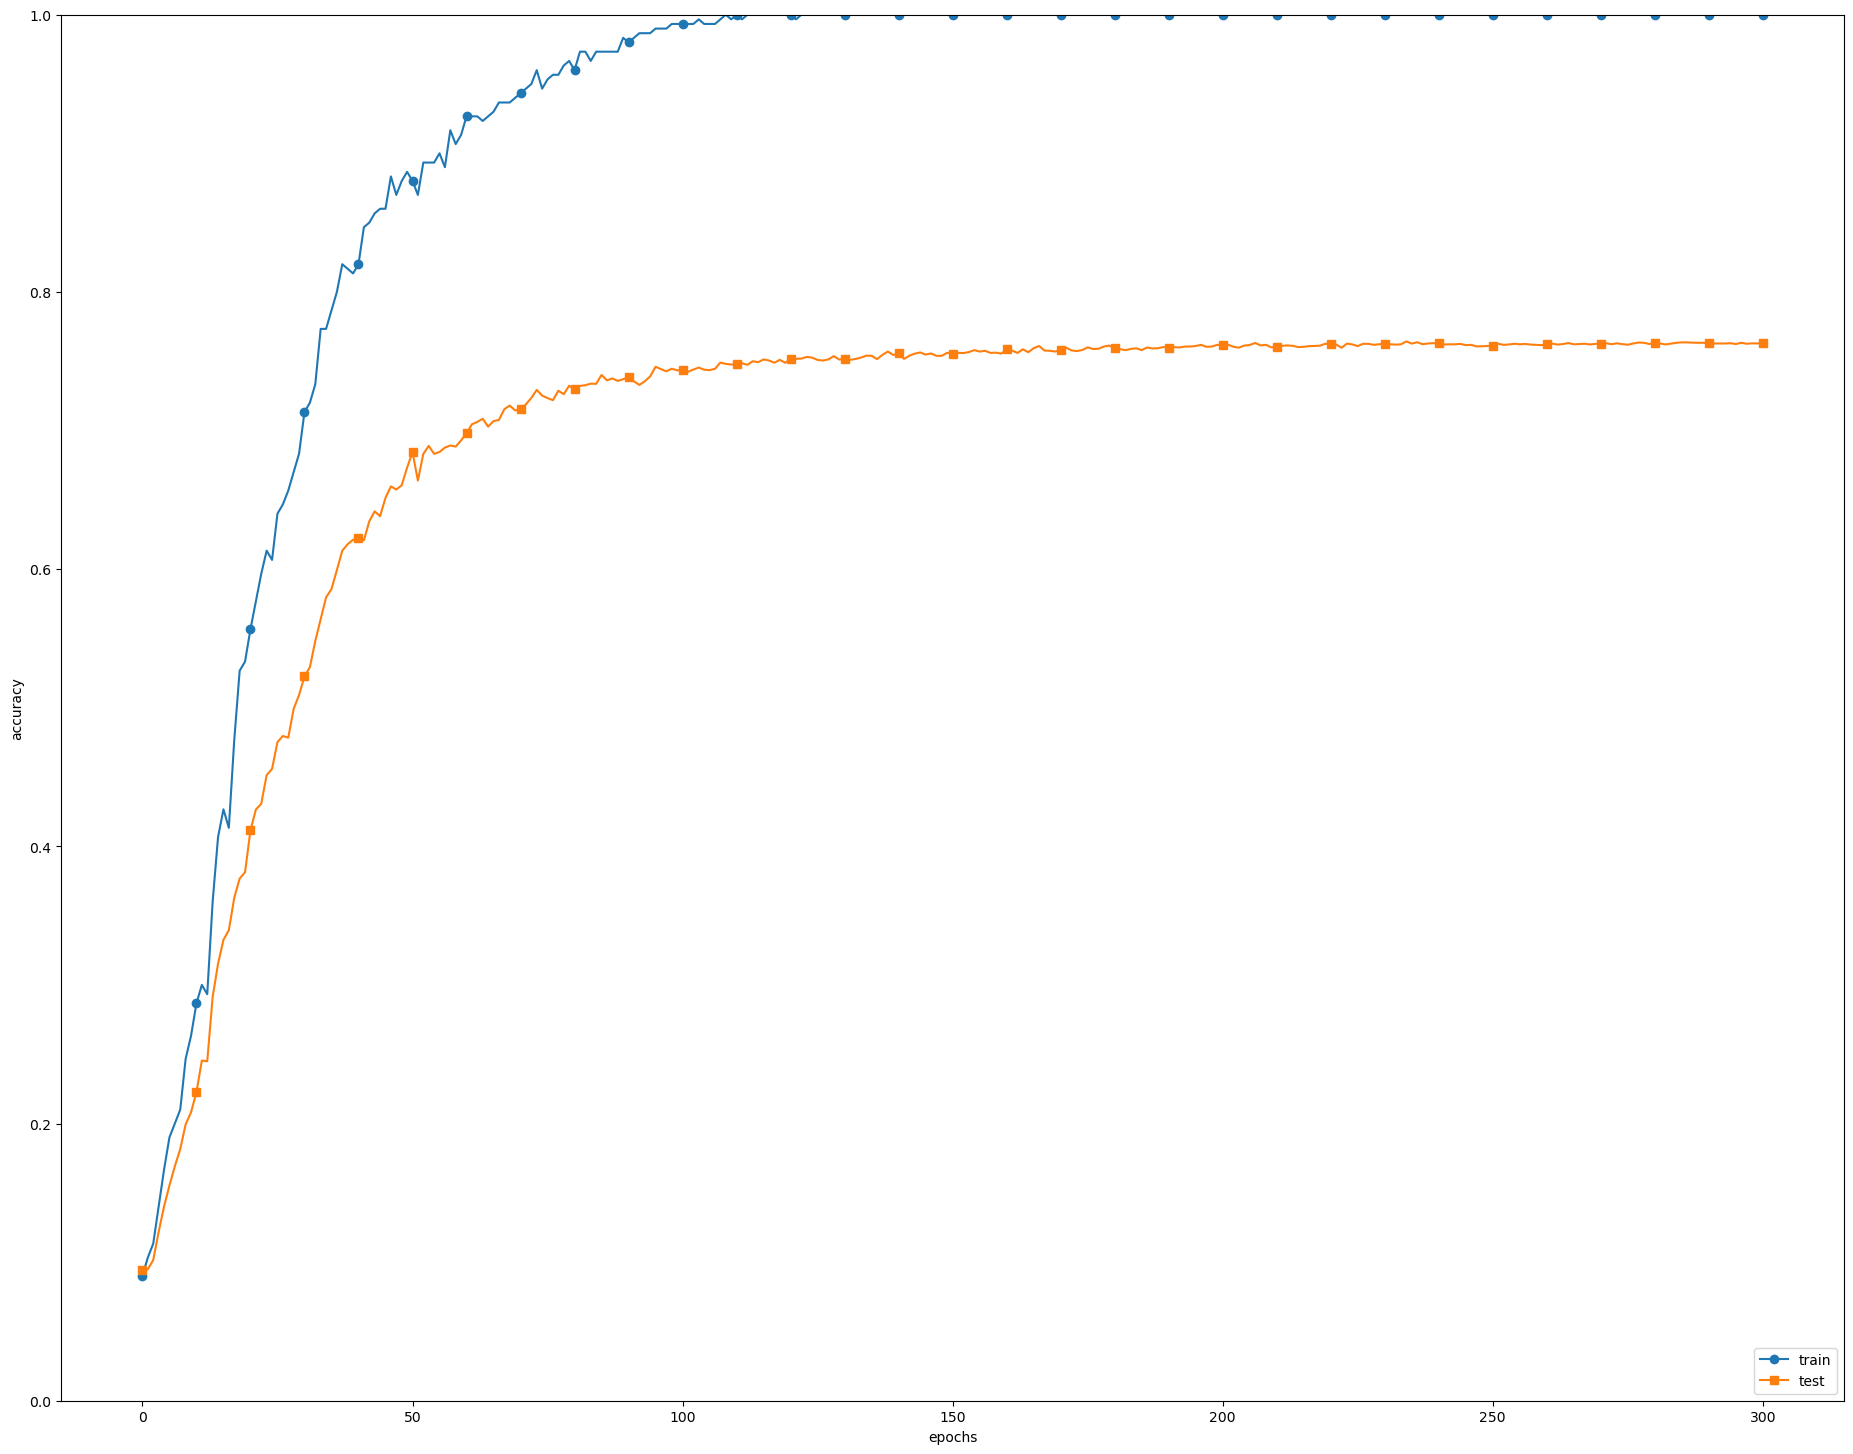

In [30]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = False  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
plt.figure(figsize=(23, 18))
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

<br>

## 6.5 적절한 하이퍼파라미터 값 찾기

### 6.5.1 검증 데이터

In [31]:
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

print(len(x_train), len(t_train))
print(len(x_test), len(t_test))

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

print(len(x_train), len(t_train))
print(len(x_val), len(t_val))

60000 60000
10000 10000
48000 48000
12000 12000


<br>

### 6.5.2 하이퍼파라미터 최적화

### 6.5.3 하이퍼파라미터 최적화 구현하기

val acc:0.61 | lr:0.004070220066293498, weight decay:3.51414584702445e-06
val acc:0.23 | lr:0.0014888249782305449, weight decay:7.042814716006293e-07
val acc:0.05 | lr:0.0001432490390971072, weight decay:2.0750496275655633e-07
val acc:0.47 | lr:0.0025564208130959432, weight decay:1.8627128433276384e-07
val acc:0.09 | lr:0.0006853620886779059, weight decay:3.220671772866263e-06
val acc:0.32 | lr:0.002637225002831162, weight decay:1.3237053193225265e-07
val acc:0.09 | lr:4.178338842623554e-06, weight decay:2.9526615915532066e-07
val acc:0.2 | lr:0.00036723708399033863, weight decay:4.0882835457122294e-08
val acc:0.08 | lr:1.2114118146367036e-05, weight decay:2.8384612430059632e-06
val acc:0.05 | lr:1.9086557274338864e-05, weight decay:8.466829181143255e-06
val acc:0.82 | lr:0.007999494984068115, weight decay:1.981765172257809e-06
val acc:0.09 | lr:5.973915869318517e-06, weight decay:1.8970222053348207e-06
val acc:0.11 | lr:1.6654736459705841e-06, weight decay:1.2968262240629691e-06
val a

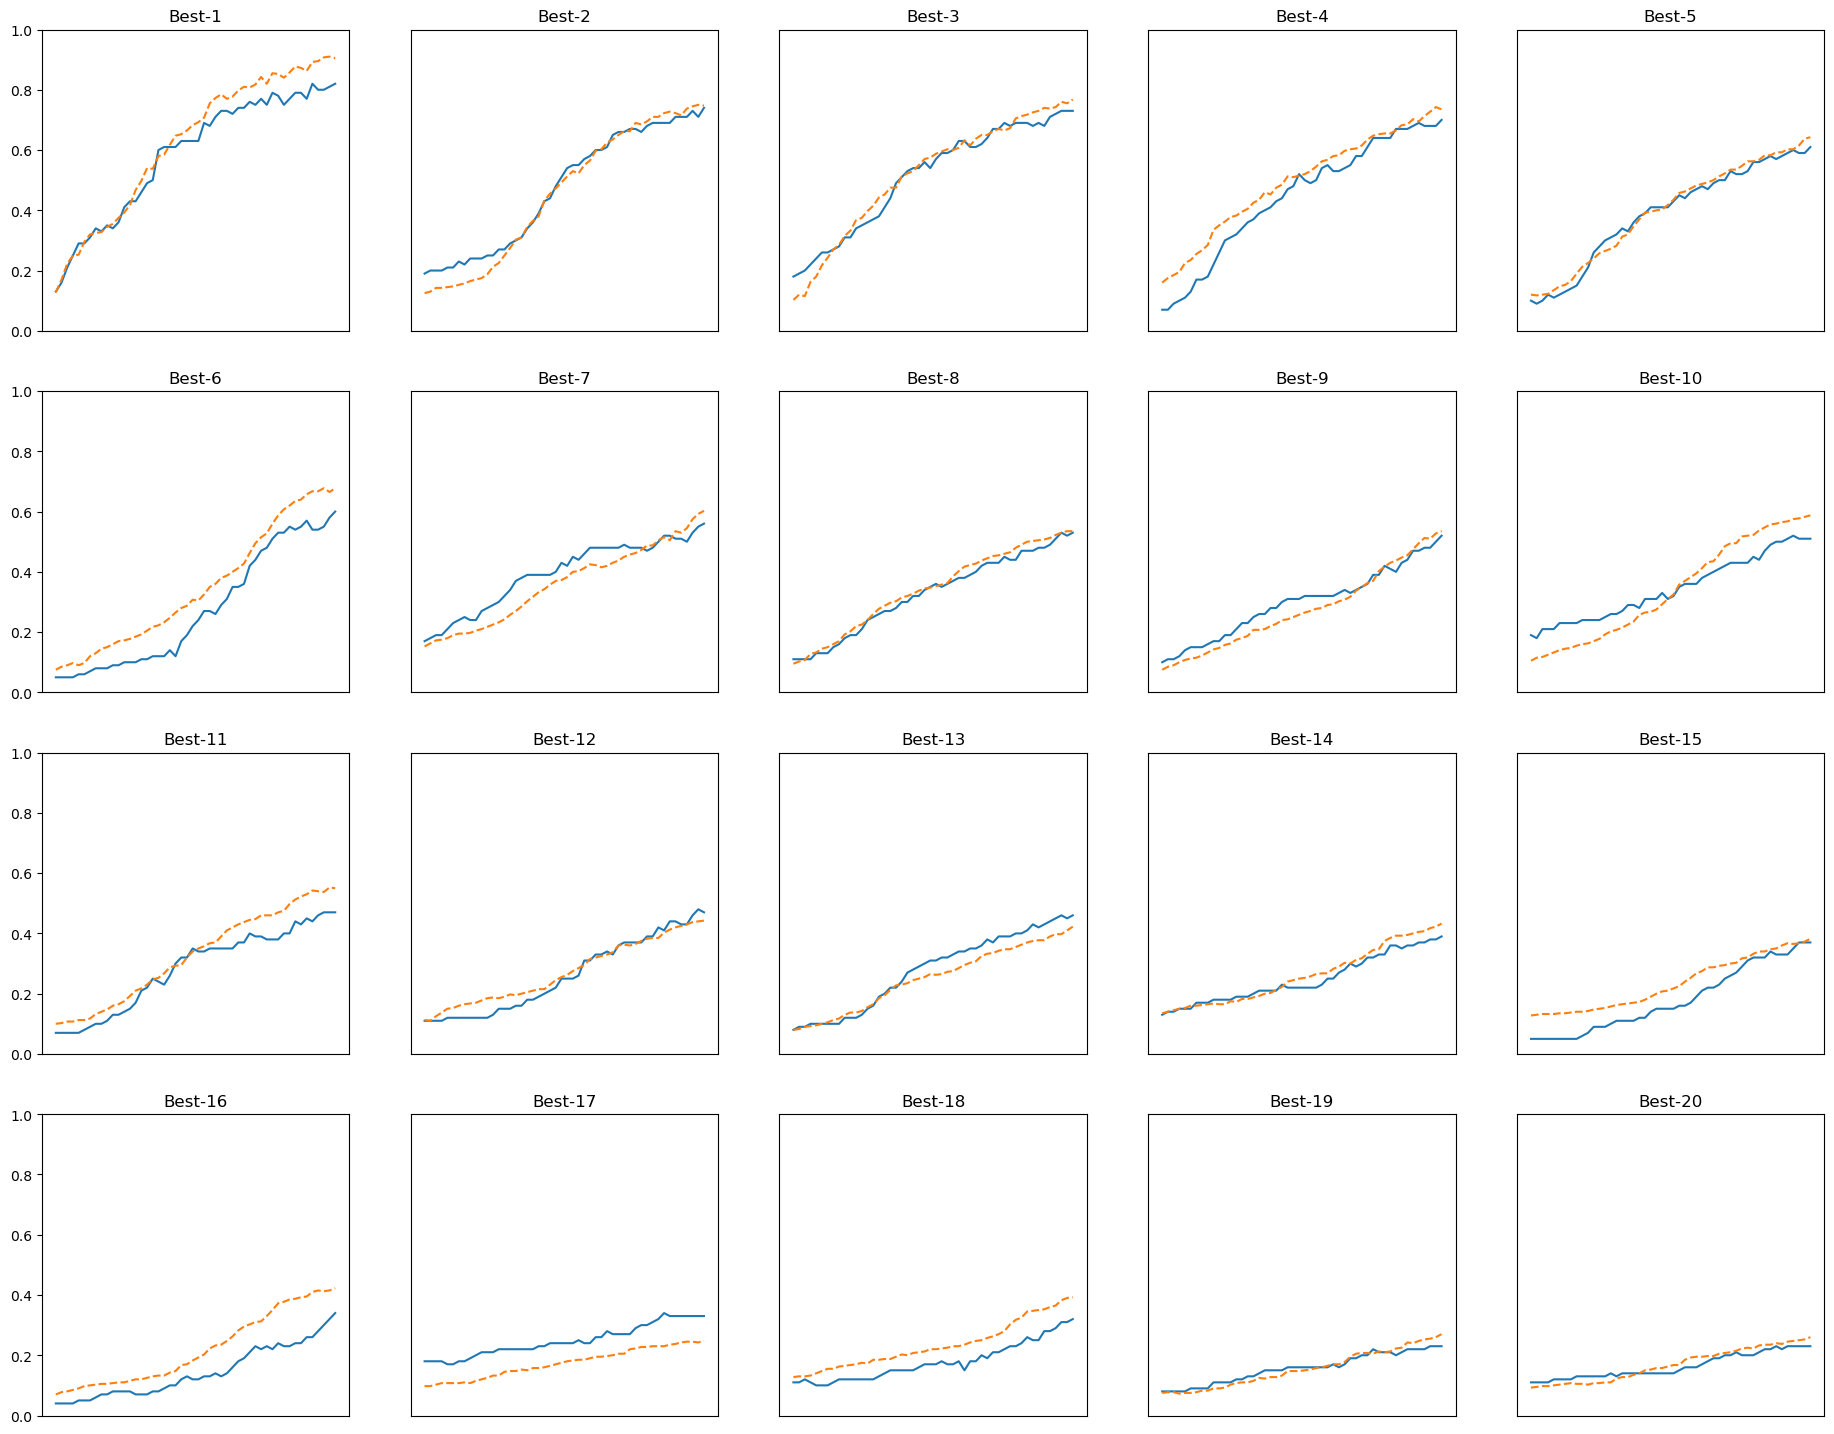

In [32]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
plt.figure(figsize=(23, 18))
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

<br>

## 6.6 정리

### 이번 장에서 배운 내용

- 매개변수 갱신 방법에는 확률적 경사하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.
- 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
- 가중치의 초깃값으로는 'Xavier 초깃값'과 'He 초깃값'이 효과적이다.
- 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.
- 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
- 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.